INSTALLING REQUIRED DEPENDENCIES

In [ ]:
!pip install datasets
!pip install transformers
!pip install -U transformers
!pip install sentencepiece
!pip install SpeechRecognition
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 31.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 82.1 MB/s eta 0:00

IMPORTING REQUIRED LIBRARIES AND MODELS

In [ ]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import speech_recognition as sr
import pickle
import transformers
import io
import base64
import re
from datasets import list_datasets, load_dataset
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW, DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from io import BytesIO
from base64 import b64decode
from google.colab import output
from IPython.display import Javascript

%matplotlib inline

In [ ]:
#removing stopwords from the text in the dataset

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# LOAD DATASET

In [ ]:
#load the dataset banking77

data = load_dataset('banking77')
data

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset banking77 downloaded and prepared to /root/.cache/huggingface/datasets/banking77/default/1.1.0/ff44c4421d7e70aa810b0fa79d36908a38b87aff8125d002cd44f7fcd31f493c. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

In [ ]:
#analyzing training dataset

data["train"]
df_train = pd.DataFrame(data["train"])

In [ ]:
#analyzing testing dataset

data["test"]
df_test = pd.DataFrame(data["test"])

In [ ]:
#reading the csv file for labelling data for intent detection

label_mappings = pd.read_csv('/content/drive/MyDrive/label-intent-banking77.csv')

In [ ]:
#Cleaning the data to use required columns

label_map=label_mappings.loc[:,["label","intent"]]

In [ ]:
label_map

,label,intent
0,0,activate_my_card
1,1,age_limit
2,2,apple_pay_or_google_pay
3,3,atm_support
4,4,automatic_top_up
...,...,...
72,72,virtual_card_not_working
73,73,visa_or_mastercard
74,74,why_verify_identity
75,75,wrong_amount_of_cash_received


DATA PREPROCESSING AND CLEANING

In [ ]:
#Training dataset

print("Train Data:")

print(df_train.head())

print(df_train.shape)

print(df_train.columns)

print(df_train.dtypes)

print(df_train.describe())



Train Data:
                                                text  label
0                     I am still waiting on my card?     11
1  What can I do if my card still hasn't arrived ...     11
2  I have been waiting over a week. Is the card s...     11
3  Can I track my card while it is in the process...     11
4  How do I know if I will get my card, or if it ...     11
(10003, 2)
Index(['text', 'label'], dtype='object')
text     object
label     int64
dtype: object
              label
count  10003.000000
mean      37.651704
std       22.391016
min        0.000000
25%       18.000000
50%       37.000000
75%       57.000000
max       76.000000


In [ ]:
#Testing dataset

print("Test Data:")

print(df_test.head())

print(df_test.shape)

print(df_test.columns)

print(df_test.dtypes)

print(df_test.describe())


Test Data:
                                                text  label
0                           How do I locate my card?     11
1  I still have not received my new card, I order...     11
2  I ordered a card but it has not arrived. Help ...     11
3   Is there a way to know when my card will arrive?     11
4                       My card has not arrived yet.     11
(3080, 2)
Index(['text', 'label'], dtype='object')
text     object
label     int64
dtype: object
            label
count  3080.00000
mean     38.00000
std      22.22972
min       0.00000
25%      19.00000
50%      38.00000
75%      57.00000
max      76.00000


In [ ]:
#splitting the train and test data to separate text and labels

train_texts = [x["text"] for x in data["train"]]
train_labels = [x["label"] for x in data["train"]]

test_texts = [x["text"] for x in data["test"]]
test_labels = [x["label"] for x in data["test"]]

train_df = pd.DataFrame(
    {'Text': train_texts,
     'Label': train_labels
    })

test_df = pd.DataFrame(
    {'Text': test_texts,
     'Label': test_labels
    })

In [ ]:
#Removing duplicate rows

unique_labels = np.unique(train_labels)
label_to_id = {label: i for i, label in enumerate(unique_labels)}

train_labels_1 = [label_to_id[label] for label in train_labels]
test_labels_1 = [label_to_id[label] for label in test_labels]

In [ ]:
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76])

In [ ]:
train_df

,Text,Label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24


In [ ]:
test_df

,Text,Label
0,How do I locate my card?,11
1,"I still have not received my new card, I order...",11
2,I ordered a card but it has not arrived. Help ...,11
3,Is there a way to know when my card will arrive?,11
4,My card has not arrived yet.,11
...,...,...
3075,"If i'm not in the UK, can I still get a card?",24
3076,How many countries do you support?,24
3077,What countries do you do business in?,24
3078,What are the countries you operate in.,24


In [ ]:
type(train_texts)

list

In [ ]:
type(train_labels)

list

In [ ]:
#Vectorizing the data using Tfidf Vectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df["Text"])
X_test = vectorizer.transform(test_df["Text"])

EXPLORATORY DATA ANALYSIS 

In [ ]:
#Counting the frequency of intent labels

intent_counts = train_df["Label"].value_counts()
print(f"Unique intent labels and their counts:\n{intent_counts}")

Unique intent labels and their counts:
15    187
28    182
6     181
75    180
19    177
     ... 
41     82
18     61
10     59
72     41
23     35
Name: Label, Length: 77, dtype: int64


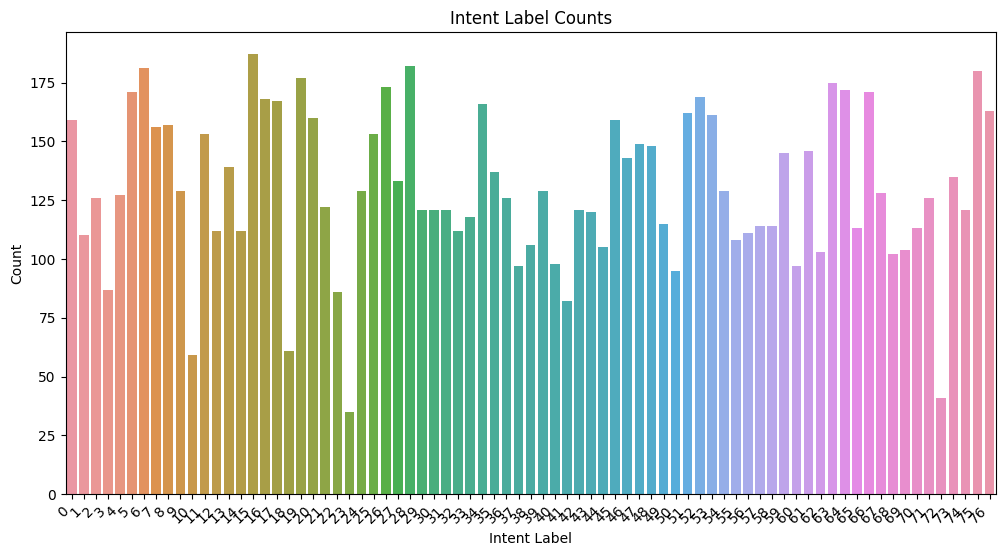

In [ ]:
# Plot a bar chart of the intent label counts

plt.figure(figsize=(12, 6))
sns.barplot(x=intent_counts.index, y=intent_counts.values)
plt.title("Intent Label Counts")
plt.xlabel("Intent Label")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

In [ ]:
# Print the average length of the text in the train set

text_lengths = train_df["Text"].apply(len)
print(f"Average text length: {text_lengths.mean()} characters")
print(f"Median text length: {text_lengths.median()}")
print(f"Standard deviation of text length: {text_lengths.std():.2f}")


Average text length: 59.47375787263821 characters
Median text length: 47.0
Standard deviation of text length: 40.87


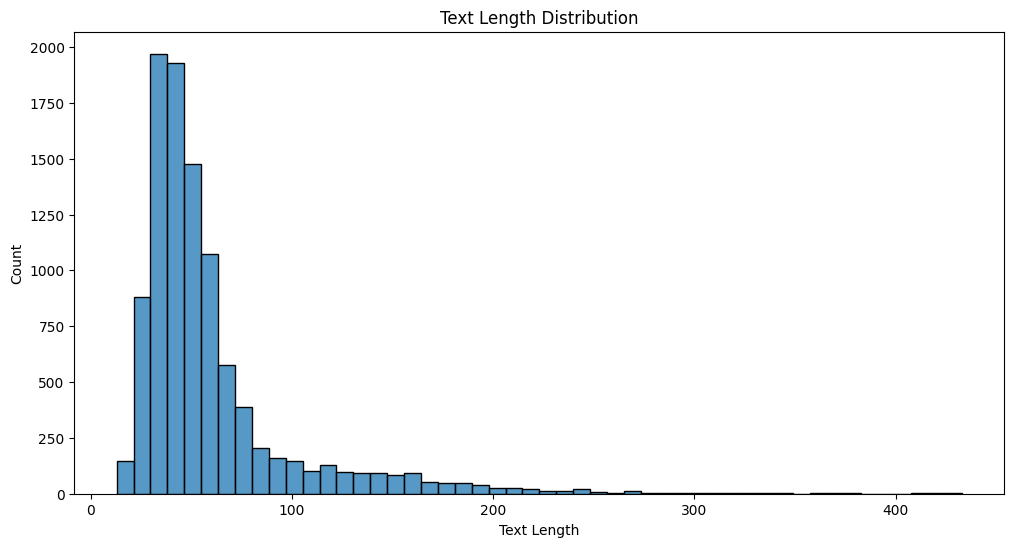

In [ ]:
# Plot a histogram of the text length distribution

plt.figure(figsize=(12, 6))
sns.histplot(text_lengths, bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

In [ ]:
df = pd.concat([pd.DataFrame(train_df), pd.DataFrame(test_df)], ignore_index=True)
df.head()

,Text,Label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


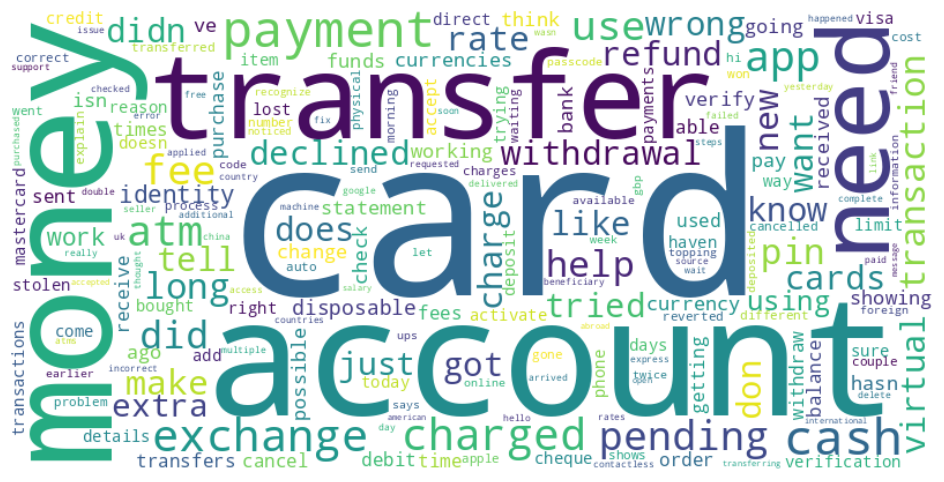

In [ ]:
# Plot a word cloud of the most common words

vectorizer = CountVectorizer(stop_words="english")
word_counts = vectorizer.fit_transform(df["Text"])
word_counts = np.array(word_counts.sum(axis=0))[0]
words = vectorizer.get_feature_names_out()
word_freq = dict(zip(words, word_counts))
wordcloud = WordCloud(background_color="white", width=800, height=400).generate_from_frequencies(word_freq)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Perform topic modeling with Latent Dirichlet Allocation

vectorizer = CountVectorizer(stop_words="english")
word_counts = vectorizer.fit_transform(df["Text"])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(word_counts)
n_top_words = 20
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx+1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Topic 1:
transfer account money exchange long rate does wrong funds bank cash pending transfers balance did check need deposit hasn right

Topic 2:
payment card pin need refund like declined change pending verify identity know account transaction cancel mastercard visa help purchase want

Topic 3:
card need use app account pay new don money using fees add help phone stolen know details lost want payments

Topic 4:
card virtual disposable cards new account able use working limit accept physical order credit verification isn cancelled haven identity auto

Topic 5:
cash charged atm fee withdrawal charge didn extra money currencies statement did app tried exchange make debit withdraw transaction currency



In [ ]:
#Calculate top 5 used words in the text for each intent
# Get the unique intents in the dataset
intents = df['Label'].unique()

# Create an empty list to store the most representative words of each class
class_words = []

# Loop through each intent and calculate the term frequency of each word in the class
for intent in intents:
    # Get the texts for this intent
    texts = df.loc[df['Label'] == intent, 'Text']

    # Check if there are any texts for this intent
    if texts.empty:
        class_words.append([])
        continue
    
    # Calculate the term frequency for each word in the texts
    word_counts = vectorizer.fit_transform(texts)
    word_counts = np.array(word_counts.sum(axis=0))[0]
    
    # Get the top 5 words with the highest frequency
    top_words = [vectorizer.get_feature_names_out()[i] for i in np.argsort(word_counts)[::-1][:5]]
    
    # Add the top words to the class_words list, fill with None if the list is empty
    if top_words:
        class_words.append(top_words)
    else:
        class_words.append([None]*5)

# Convert the class_words list to a DataFrame
class_words_df = pd.DataFrame(class_words, columns=['Word 1', 'Word 2', 'Word 3', 'Word 4', 'Word 5'])

<ipython-input-32-e3b7cc78d5d0>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)


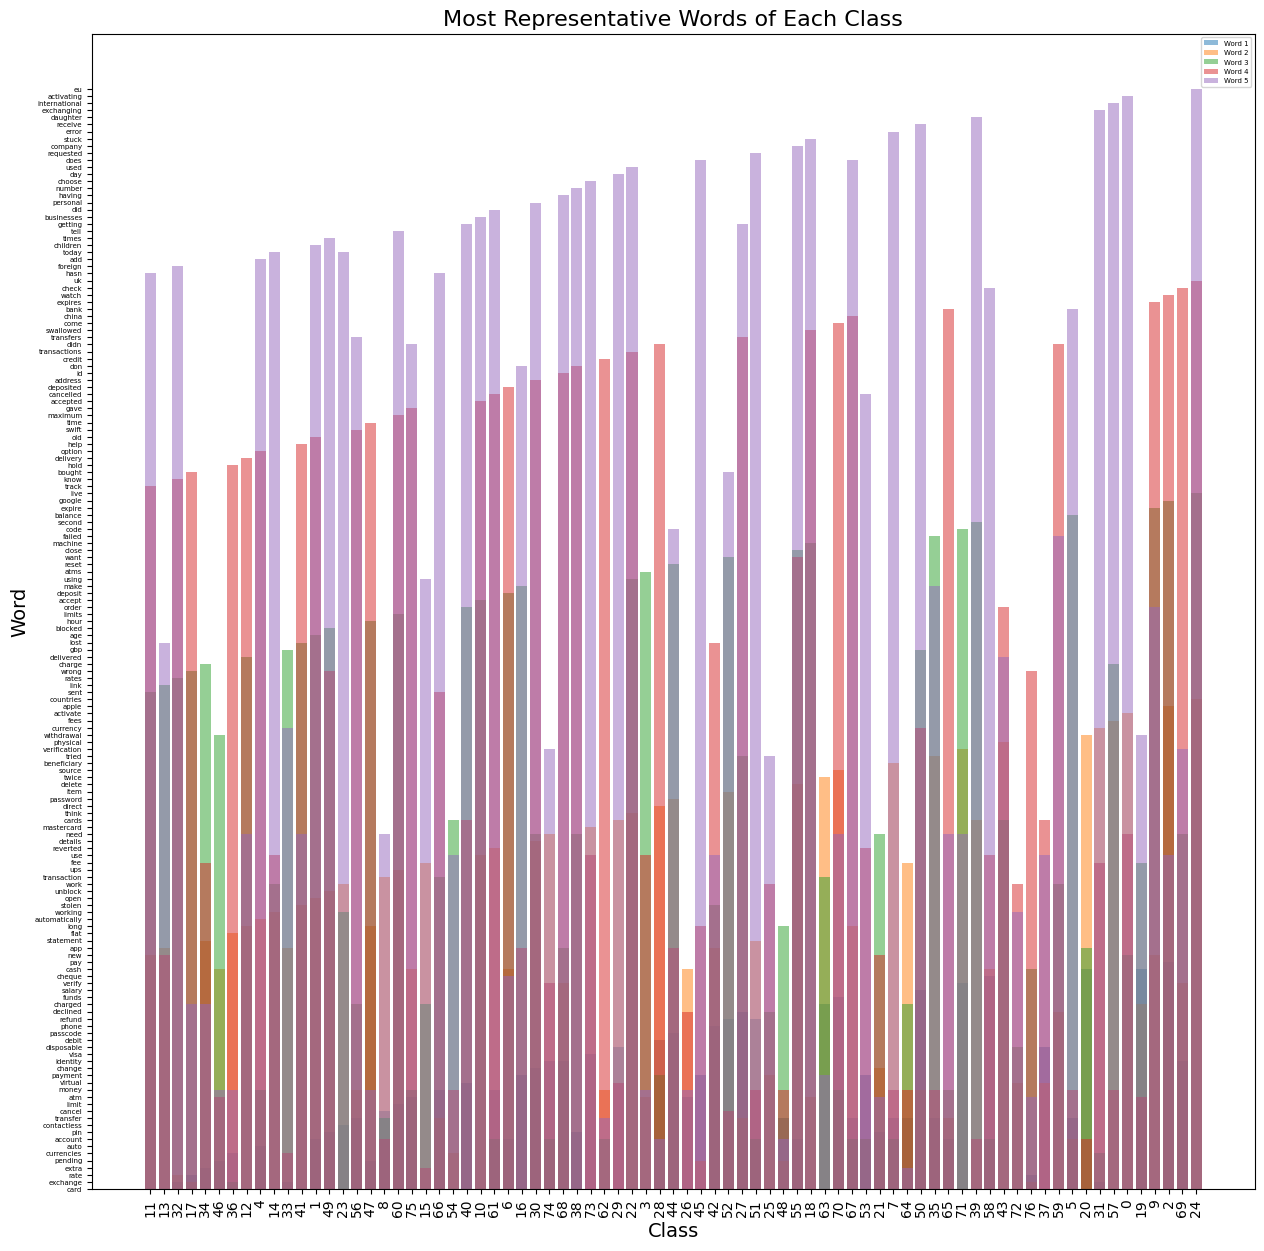

In [ ]:
# Create a bar plot for top 5 used words in the text for each intent

fig, ax = plt.subplots(figsize=(15, 15))
x_ticks = range(len(class_words_df))

for i in range(5):
    ax.bar(x_ticks, class_words_df[f'Word {i+1}'], alpha=0.5, label=f'Word {i+1}')

# Set the axis labels and title
ax.set_xticks(x_ticks)
ax.set_xticklabels(intents, rotation=90, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)
ax.set_title('Most Representative Words of Each Class', fontsize=16)
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Word', fontsize=14)

# Add a legend
ax.legend(fontsize=5)

# Show the plot
plt.show()


# BASELINE ALGORITHMS AND RESULTS - USING CONVENTIONAL ML ALGORITHMS

Random Forest Model

In [ ]:
#Random Forest  - model creation

randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(X_train, train_df["Label"])

RandomForestClassifier()

In [ ]:
#Random Forest  - Model Test

y_pred_rf = randomforest.predict(X_test)

In [ ]:
#Print metrics for comparison

print("Classification Report ::: Random Forest \n", classification_report(test_df["Label"], y_pred_rf))

Classification Report ::: Random Forest 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        40
           1       0.93      1.00      0.96        40
           2       0.98      1.00      0.99        40
           3       0.97      0.88      0.92        40
           4       1.00      0.93      0.96        40
           5       0.58      0.62      0.60        40
           6       0.84      0.90      0.87        40
           7       0.94      0.82      0.88        40
           8       0.89      1.00      0.94        40
           9       0.93      0.97      0.95        40
          10       0.80      0.70      0.75        40
          11       0.88      0.88      0.88        40
          12       0.83      0.85      0.84        40
          13       0.89      1.00      0.94        40
          14       0.78      0.90      0.84        40
          15       0.89      0.85      0.87        40
          16       0.72      0.72      

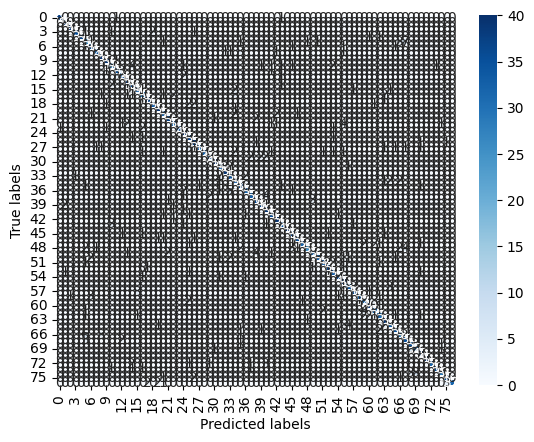

In [ ]:
# Create a confusion matrix to visualize the performance of the model

cm = confusion_matrix(test_df["Label"], y_pred_rf)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()


In [ ]:
# Plotting the classification metrics for Random Forest

In [ ]:
report_rf=classification_report(test_df["Label"],y_pred_rf,output_dict=True)
macro_precision_rf =  report_rf['macro avg']['precision'] 
macro_recall_rf = report_rf['macro avg']['recall']    
macro_f1_rf = report_rf['macro avg']['f1-score']
accuracy_rf = report_rf['accuracy']

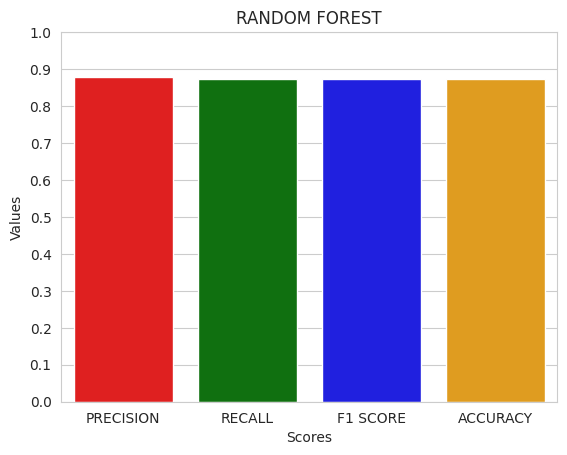

In [ ]:
data = {'Variables': ['PRECISION', 'RECALL', 'F1 SCORE', 'ACCURACY'],
        'Values': [macro_precision_rf, macro_recall_rf, macro_f1_rf, accuracy_rf],
         'Colors': ['red', 'green', 'blue', 'orange']}

sns.set_style("whitegrid")
sns.barplot(x="Variables", y="Values", data=data,palette=data['Colors'])
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(0, 11)])

plt.title('RANDOM FOREST')
plt.xlabel('Scores')
plt.ylabel('Values')

plt.show()

Linear SVC Model

In [ ]:
#Linear SVC - model creation

clf = LinearSVC()
clf.fit(X_train, train_labels_1)

LinearSVC()

In [ ]:
#Linear SVC  - Model Test

y_pred = clf.predict(X_test)

In [ ]:
#Print metrics for comparison

print("Classification Report ::: Linear SVC \n", classification_report(test_df["Label"], y_pred))

Classification Report ::: Linear SVC 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.95      1.00      0.98        40
           2       0.98      1.00      0.99        40
           3       0.91      0.97      0.94        40
           4       0.97      0.97      0.97        40
           5       0.69      0.78      0.73        40
           6       0.93      0.95      0.94        40
           7       0.97      0.88      0.92        40
           8       0.97      0.95      0.96        40
           9       0.97      0.97      0.97        40
          10       0.91      0.80      0.85        40
          11       0.89      0.85      0.87        40
          12       0.86      0.90      0.88        40
          13       0.97      0.97      0.97        40
          14       0.69      0.85      0.76        40
          15       0.92      0.90      0.91        40
          16       0.85      0.85      0.8

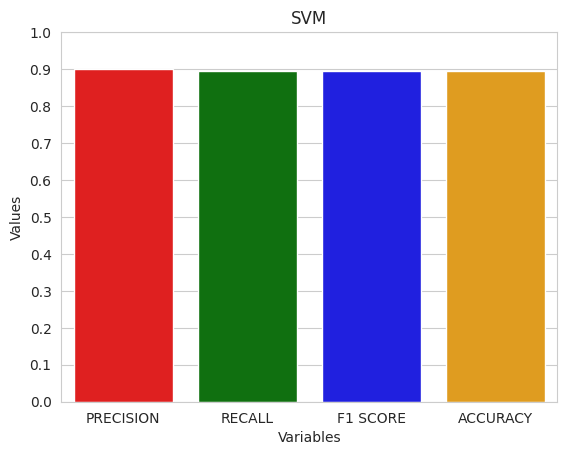

In [ ]:
# Calculate accuracy, precision, recall, and F1-score
report_svm=classification_report(test_df["Label"],y_pred,output_dict=True)
macro_precision_svm =  report_svm['macro avg']['precision'] 
macro_recall_svm = report_svm['macro avg']['recall']    
macro_f1_svm = report_svm['macro avg']['f1-score']
accuracy_svm = report_svm['accuracy']

# Plot the results in a bar chart

data = {'Variables': ['PRECISION', 'RECALL', 'F1 SCORE', 'ACCURACY'],
        'Values': [macro_precision_svm, macro_recall_svm, macro_f1_svm, accuracy_svm],
         'Colors': ['red', 'green', 'blue', 'orange']}

sns.set_style("whitegrid")
sns.barplot(x="Variables", y="Values", data=data,palette=data['Colors'])
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(0, 11)])

plt.title('SVM')
plt.xlabel('Variables')
plt.ylabel('Values')

plt.show()

# IMPROVED MODELS AND EXPERIMENTS - USING LANGUAGE MODELS AND RESULTS

ALbert Model

In [ ]:
#Albert Model 

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(unique_labels))

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

In [ ]:
#Create encodings for dataset using pre trained Albert model

def tokenize(texts, labels):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(text, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_tensors='pt')
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return TensorDataset(input_ids, attention_masks, labels)

train_dataset = tokenize(train_texts, train_labels)
test_dataset = tokenize(test_texts, test_labels)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
test_loader

In [ ]:
train_loader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [ ]:
#Fine tuning Albert model on our data to calculate

optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()

    train_loss = 0
    train_correct = 0
    train_total = 0

    for input_ids, attention_masks, labels in train_loader:
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_accuracy = train_correct / train_total
    train_loss /= len(train_loader)

    model.eval()

    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for input_ids, attention_masks, labels in test_loader:
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, predicted = torch.max(logits, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            test_loss += loss.item()

    test_accuracy = test_correct / test_total
    test_loss /= len(test_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Train Loss: 2.7773, Train Accuracy: 0.4406, Test Loss: 1.4317, Test Accuracy: 0.7286
Epoch 2/5, Train Loss: 0.8969, Train Accuracy: 0.8394, Test Loss: 0.6914, Test Accuracy: 0.8636
Epoch 3/5, Train Loss: 0.4507, Train Accuracy: 0.9118, Test Loss: 0.4675, Test Accuracy: 0.8977
Epoch 4/5, Train Loss: 0.2814, Train Accuracy: 0.9429, Test Loss: 0.4217, Test Accuracy: 0.9026
Epoch 5/5, Train Loss: 0.1971, Train Accuracy: 0.9585, Test Loss: 0.4204, Test Accuracy: 0.8958


In [ ]:
#Testing using Albert

model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for input_ids, attention_masks, labels in test_loader:
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

target_names = unique_labels.tolist()

In [ ]:
#Print classification report

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.98      1.00      0.99        40
           2       1.00      1.00      1.00        40
           3       0.91      1.00      0.95        40
           4       0.95      0.88      0.91        40
           5       0.92      0.57      0.71        40
           6       1.00      0.90      0.95        40
           7       0.94      0.85      0.89        40
           8       0.97      0.93      0.95        40
           9       0.98      1.00      0.99        40
          10       0.80      0.90      0.85        40
          11       0.97      0.80      0.88        40
          12       0.85      0.88      0.86        40
          13       1.00      0.88      0.93        40
          14       0.86      0.90      0.88        40
          15       0.86      0.95      0.90        40
          16       0.87      0.68      0.76        40
          17       0.90    

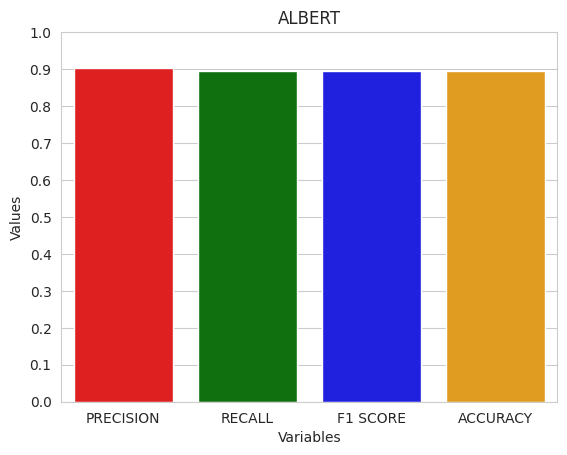

In [ ]:
# Calculate accuracy, precision, recall, and F1-score
report=classification_report(true_labels, predicted_labels,output_dict=True)
macro_precision_al =  report['macro avg']['precision'] 
macro_recall_al = report['macro avg']['recall']    
macro_f1_al = report['macro avg']['f1-score']
accuracy_al = report['accuracy']

# Plot the results in a bar chart

data = {'Variables': ['PRECISION', 'RECALL', 'F1 SCORE', 'ACCURACY'],
        'Values': [macro_precision_al, macro_recall_al, macro_f1_al, accuracy_al],
         'Colors': ['red', 'green', 'blue', 'orange']}

sns.set_style("whitegrid")
sns.barplot(x="Variables", y="Values", data=data,palette=data['Colors'])
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(0, 11)])

plt.title('ALBERT')
plt.xlabel('Variables')
plt.ylabel('Values')

plt.show()


Distil BERT Model

In [ ]:
#Creating encodings using DistilBert

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(train_df['Text']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['Text']), truncation=True, padding=True)

In [ ]:
# Create PyTorch tensors

train_input_ids = torch.tensor(train_encodings['input_ids'])
train_attention_mask = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels_1)

test_input_ids = torch.tensor(test_encodings['input_ids'])
test_attention_mask = torch.tensor(test_encodings['attention_mask'])
test_labels = torch.tensor(test_labels_1)

# Create a PyTorch DataLoader
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
#Using pre-trained DistilBert model

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

In [ ]:
# Train the model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            pred = torch.argmax(logits, axis=1)
            true_labels += list(labels.cpu().numpy())
            pred_labels += list(pred.cpu().numpy())

In [ ]:
#Printing classification report

print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40
           3       0.98      1.00      0.99        40
           4       0.95      1.00      0.98        40
           5       0.72      0.82      0.77        40
           6       0.97      0.95      0.96        40
           7       0.97      0.85      0.91        40
           8       1.00      0.93      0.96        40
           9       0.98      1.00      0.99        40
          10       0.92      0.90      0.91        40
          11       0.86      0.93      0.89        40
          12       0.95      0.88      0.91        40
          13       0.97      0.97      0.97        40
          14       0.84      0.95      0.89        40
          15       0.81      0.95      0.87        40
          16       0.88      0.88      0.88        40
          17       0.97    

Text(0, 0.5, 'Values')

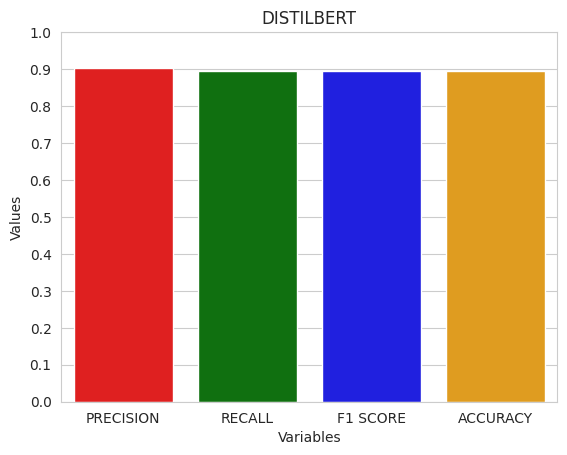

In [ ]:

# Calculate accuracy, precision, recall, and F1-score

report=classification_report(true_labels, predicted_labels,output_dict=True)
macro_precision_di =  report['macro avg']['precision'] 
macro_recall_di = report['macro avg']['recall']    
macro_f1_di = report['macro avg']['f1-score']
accuracy_di = report['accuracy']

# Plot the results in a bar chart

data = {'Variables': ['PRECISION', 'RECALL', 'F1 SCORE', 'ACCURACY'],
        'Values': [macro_precision_di, macro_recall_di, macro_f1_di, accuracy_di],
         'Colors': ['red', 'green', 'blue', 'orange']}

sns.set_style("whitegrid")
sns.barplot(x="Variables", y="Values", data=data,palette=data['Colors'])
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(0, 11)])

plt.title('DISTILBERT')
plt.xlabel('Variables')
plt.ylabel('Values')



RoBERTa Model - Best Accuracy Model

In [ ]:
#Tokenize the data using the RoBERTa tokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_df['Text'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['Text'].tolist(), truncation=True, padding=True)

In [ ]:
# Create PyTorch DataLoader objects
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(train_labels_1))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']), torch.tensor(test_labels_1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the RoBERTa model and the optimizer
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(unique_labels))
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [ ]:
# Train the model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()
for epoch in range(5):
    for batch in train_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

In [ ]:
# Evaluate the model

model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        batch_predictions = torch.argmax(probs, dim=1)
        predictions.extend(batch_predictions.cpu().numpy().tolist())


In [ ]:
# Print the classification report

print(classification_report(test_labels_1, predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40
           3       0.98      1.00      0.99        40
           4       1.00      1.00      1.00        40
           5       0.81      0.75      0.78        40
           6       1.00      0.85      0.92        40
           7       1.00      0.85      0.92        40
           8       1.00      0.88      0.93        40
           9       1.00      0.88      0.93        40
          10       1.00      0.88      0.93        40
          11       0.74      0.97      0.84        40
          12       0.97      0.75      0.85        40
          13       1.00      0.93      0.96        40
          14       0.91      0.97      0.94        40
          15       0.92      0.85      0.88        40
          16       0.80      0.90      0.85        40
          17       0.95    

Text(0, 0.5, 'Values')

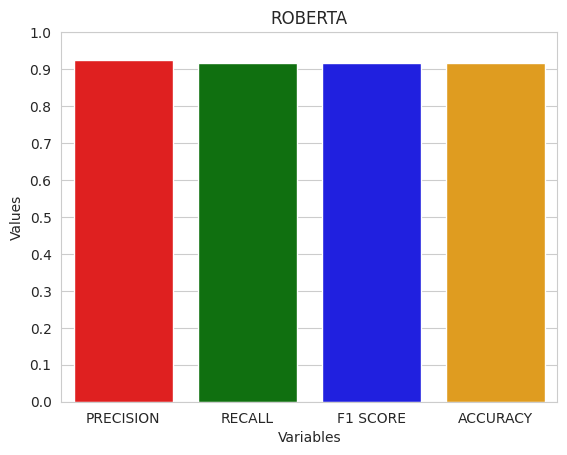

In [ ]:

# Calculate accuracy, precision, recall, and F1-score

report=classification_report(test_labels_1, predictions,output_dict=True)
macro_precision_ro =  report['macro avg']['precision'] 
macro_recall_ro = report['macro avg']['recall']    
macro_f1_ro = report['macro avg']['f1-score']
accuracy_ro = report['accuracy']

# Plot the results in a bar chart

data = {'Variables': ['PRECISION', 'RECALL', 'F1 SCORE', 'ACCURACY'],
        'Values': [macro_precision_ro, macro_recall_ro, macro_f1_ro, accuracy_ro],
         'Colors': ['red', 'green', 'blue', 'orange']}

sns.set_style("whitegrid")
sns.barplot(x="Variables", y="Values", data=data,palette=data['Colors'])
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(0, 11)])

plt.title('ROBERTA')
plt.xlabel('Variables')
plt.ylabel('Values')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# TESTING USING SPEECH RECOGNITION

In [ ]:
# Load the speech recognition library and the trained RoBERTa model
import pydub
from pydub import AudioSegment
r = sr.Recognizer()

# Define a function to transcribe speech input and label it using the RoBERTa model
def recognize_speech(audio_bytes):
    audio = AudioSegment.from_file(io.BytesIO(audio_bytes))
    with io.BytesIO() as wav_file:
        audio.export(wav_file, format="wav")
        wav_file.seek(0)

        # Use the speech recognition library to transcribe speech input
        with sr.AudioFile(wav_file) as source:
            audio = r.record(source)
        text = r.recognize_google(audio)
        print("Your input:", text)

    # Preprocess the text by lowercasing and removing special characters
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9 \n\.]', '', text)

    # Tokenize the text using the RoBERTa tokenizer
    tokenized_text = tokenizer(text, truncation=True, padding=True)

    # Convert the tokenized text into input encodings
    input_ids = torch.tensor([tokenized_text['input_ids']]).to(device)
    attention_mask = torch.tensor([tokenized_text['attention_mask']]).to(device)

    # Pass the input encodings through the RoBERTa model to obtain the predicted label
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()

    # Map the predicted label back to the original label using the label_map dictionary
    label = label_map[label_map['label']==prediction]['intent'].values[0]

    return label

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  print("Speak Now...")
  display(Javascript(RECORD))
  sec += 1
  s = output.eval_js('record(%d)' % (sec*1000))
  print("Done Recording !")
  b = b64decode(s.split(',')[1])
  print("The suggested label for your input:", recognize_speech(b)) #byte stream

record()

Speak Now...


<IPython.core.display.Javascript object>

Done Recording !
Your input: where is the nearest ATM
The suggested label for your input: atm_support


In [ ]:
# Load the speech recognition library and the trained RoBERTa model

r = sr.Recognizer()

# Define a function to transcribe speech input and label it using the RoBERTa model
def recognize_speech(audio_bytes):
    audio = AudioSegment.from_file(io.BytesIO(audio_bytes))
    with io.BytesIO() as wav_file:
        audio.export(wav_file, format="wav")
        wav_file.seek(0)

        # Use the speech recognition library to transcribe speech input
        with sr.AudioFile(wav_file) as source:
            audio = r.record(source)
        text = r.recognize_google(audio)
        print("Your input:", text)

    # Preprocess the text by lowercasing and removing special characters
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9 \n\.]', '', text)

    # Tokenize the text using the RoBERTa tokenizer
    tokenized_text = tokenizer(text, truncation=True, padding=True)

    # Convert the tokenized text into input encodings
    input_ids = torch.tensor([tokenized_text['input_ids']]).to(device)
    attention_mask = torch.tensor([tokenized_text['attention_mask']]).to(device)

    # Pass the input encodings through the RoBERTa model to obtain the predicted label
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()

    # Map the predicted label back to the original label using the label_map dictionary
    label = label_map[label_map['label']==prediction]['intent'].values[0]

    return label

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  print("Speak Now...")
  display(Javascript(RECORD))
  sec += 1
  s = output.eval_js('record(%d)' % (sec*1000))
  print("Done Recording !")
  b = b64decode(s.split(',')[1])
  print("The suggested label for your input:", recognize_speech(b)) #byte stream

record()

Speak Now...


<IPython.core.display.Javascript object>

Done Recording !
Your input: can I do auto top up on my cibc savings account
The suggested label for your input: automatic_top_up


In [ ]:
# Load the speech recognition library and the trained RoBERTa model

r = sr.Recognizer()

# Define a function to transcribe speech input and label it using the RoBERTa model
def recognize_speech(audio_bytes):
    audio = AudioSegment.from_file(io.BytesIO(audio_bytes))
    with io.BytesIO() as wav_file:
        audio.export(wav_file, format="wav")
        wav_file.seek(0)

        # Use the speech recognition library to transcribe speech input
        with sr.AudioFile(wav_file) as source:
            audio = r.record(source)
        text = r.recognize_google(audio)
        print("Your input:", text)

    # Preprocess the text by lowercasing and removing special characters
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9 \n\.]', '', text)

    # Tokenize the text using the RoBERTa tokenizer
    tokenized_text = tokenizer(text, truncation=True, padding=True)

    # Convert the tokenized text into input encodings
    input_ids = torch.tensor([tokenized_text['input_ids']]).to(device)
    attention_mask = torch.tensor([tokenized_text['attention_mask']]).to(device)

    # Pass the input encodings through the RoBERTa model to obtain the predicted label
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()

    # Map the predicted label back to the original label using the label_map dictionary
    label = label_map[label_map['label']==prediction]['intent'].values[0]

    return label

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  print("Speak Now...")
  display(Javascript(RECORD))
  sec += 1
  s = output.eval_js('record(%d)' % (sec*1000))
  print("Done Recording !")
  b = b64decode(s.split(',')[1])
  print("The suggested label for your input:", recognize_speech(b)) #byte stream

record()

Speak Now...


<IPython.core.display.Javascript object>

Done Recording !
Your input: can I withdraw cash from RBC checking's account
The suggested label for your input: verify_source_of_funds
